<a href="https://colab.research.google.com/github/gmp007/perovskene-materials/blob/main/PerovskeneModeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install periodictable
!pip install catboost
!pip install kaleido
!pip install pymatgen
!pip install matminer

In [2]:
!pip install -U shap

In [3]:
# If you're running on Google Colab, you might some times get the error "numpy.linalg._umath_linalg". Just restart the kernel and continue from below

In [4]:
import numpy as np
import pandas as pd
import periodictable
import re
import seaborn as sns
import shap
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from numpy import sort
from sklearn.preprocessing import StandardScaler
from pymatgen.core.composition import Composition
from matminer.featurizers.composition import ElectronAffinity, ElementFraction
from sklearn.model_selection import (
    train_test_split, cross_val_score, cross_val_predict,
    KFold, RepeatedKFold, ShuffleSplit, cross_validate
)
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression, SelectFromModel
from sklearn.ensemble import (
    RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
)
from sklearn.linear_model import (
    LinearRegression, SGDRegressor, BayesianRidge, LassoLars, LassoLarsCV,
    ARDRegression
)
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import svm, metrics, linear_model
from sklearn.metrics import (
    r2_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
)
from sklearn.cross_decomposition import PLSRegression
from xgboost import XGBRFRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import plotly.express as px
import plotly.io as pio
import os
import itertools

rndseem = 110
test_size = 0.20
savplt = True
hyperparameter = True
remove_outliers = False

In [5]:
dataplots = './' #Specify the directory where you want to save your plots

In [6]:
# Load the data. This is the version that is alredy cleaned
data = pd.read_csv('perovskene_ppts.csv')

In [7]:
data.head()

,Material,WorkFxn,mag_moment,Bandgap,lat_const,C11,C12,Y2D,G,K,v,V_l,V_s,V_m,T_D
0,Ba2Cr2Cl6,1.708378,8.714,0.1965,6.908,32.30,21.69,17.73,5.30,27.00,0.67,3.69,1.49,1.96,260.70
1,Ba2Mn2F6,1.797230,5.460,0.5112,5.836,40.52,13.35,36.12,13.58,26.93,0.33,3.80,2.20,2.69,424.31
2,Ba2Ti2Cl6,1.868425,4.648,0.4935,7.253,11.56,11.07,0.96,0.25,11.31,0.96,2.33,0.34,0.48,60.29
3,Ba2Mn2Br6,1.908017,8.065,0.1615,7.225,34.53,18.75,24.35,7.89,26.64,0.54,3.30,1.58,2.01,256.11
4,Sr2Mn2Br6,1.982117,8.398,0.2552,7.155,26.28,21.51,8.67,2.38,23.89,0.82,3.03,0.91,1.24,158.85


In [8]:
# Use groupby to rotate the plot
def plot_top_materials_by_avg(data, tagname, groupby_col, avg_col, top_bottom=True, top_n=10,savplt=False):
    """
    Plots the top N materials based on the average value of a specified column.

    Parameters:
    - data (DataFrame): The dataset containing material properties.
    - groupby_col (str): The column to group by (typically 'Material').
    - avg_col (str): The column whose average value is to be calculated.
    - top_n (int): Number of top materials to display.

    Returns:
    - None. Displays the plot.
    """

    # Grouping by 'groupby_col' and calculating the mean of 'avg_col'



    if top_bottom:
        grouped_data = data.groupby(groupby_col)[avg_col].mean().sort_values(ascending=False)
    else:
        grouped_data = data.groupby(groupby_col)[avg_col].mean().sort_values(ascending=True)



    # Selecting the top N materials based on average value
    top_materials = grouped_data.head(top_n)

    plt.figure(figsize=(12, 9))

    # Define a color palette
    colors = sns.color_palette("rainbow", top_n)
    color_rank = np.argsort(np.argsort(top_materials))  # Rank the sorted data for coloring

    bars = plt.barh(top_materials.index, top_materials.values, color=np.array(colors)[color_rank])
    plt.title(f'Top {top_n} Materials by Average {avg_col} Value for {tagname}', fontsize=16, fontweight='bold')
    plt.ylabel(groupby_col, fontsize=20)
    plt.xlabel(f'Average {avg_col} Value', fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.tight_layout()
    plt.grid(axis='x', linestyle='--', linewidth=0.7, alpha=0.6)
    plt.gca().invert_yaxis()  # To display the material with the highest average at the top

    # Add data labels next to each bar
    for bar in bars:
        plt.text(bar.get_width() - 0.02 * top_materials.values.max(), bar.get_y() + bar.get_height()/2,
                 f"{bar.get_width():.2f}",
                 va='center', ha='right', color='black', fontsize=10)


    if savplt:
        filename = f'{dataplots}/groupyTop_{top_n}_{tagname}_materials_by_{avg_col}.png'
        plt.savefig(filename, dpi=400, bbox_inches='tight')
        #plt.close()
    plt.show()

In [9]:
# Function to sort multicolumns. We will also use plotly for interactive plots below

def select_and_save_materials_flexible_sort(df, tagname, sort_columns, ascending_order, count=10, display_columns=None, savplt=False):
    """
    Function to select and display materials based on specified columns and their respective sorting orders.
    If savplt is True, the selected data will be saved to an Excel file at the specified path.
    """
    if isinstance(sort_columns, str):
        sort_columns = [sort_columns]  # Convert to list if only a single column is provided

    if isinstance(ascending_order, bool):
        ascending_order = [ascending_order]  # Convert to list if only a single value is provided

    # Ensure that the length of sort_columns and ascending_order are the same
    assert len(sort_columns) == len(ascending_order), "Length of sort_columns and ascending_order must be the same."

    sorted_data = df.sort_values(by=sort_columns, ascending=ascending_order).head(count)

    # Display the materials
    if display_columns:
        display(sorted_data[display_columns])
    else:
        display(sorted_data)

    # Save to excel if savplt is True
    if savplt:
        if display_columns:
            selected_data = sorted_data[display_columns]
        else:
            selected_data = sorted_data
        columns_str = "_and_".join(sort_columns)
        filename = f"{dataplots}/{tagname}_selected_{count}_materials_sorted_by_{columns_str}.xlsx"
        selected_data.to_excel(filename, index=False)

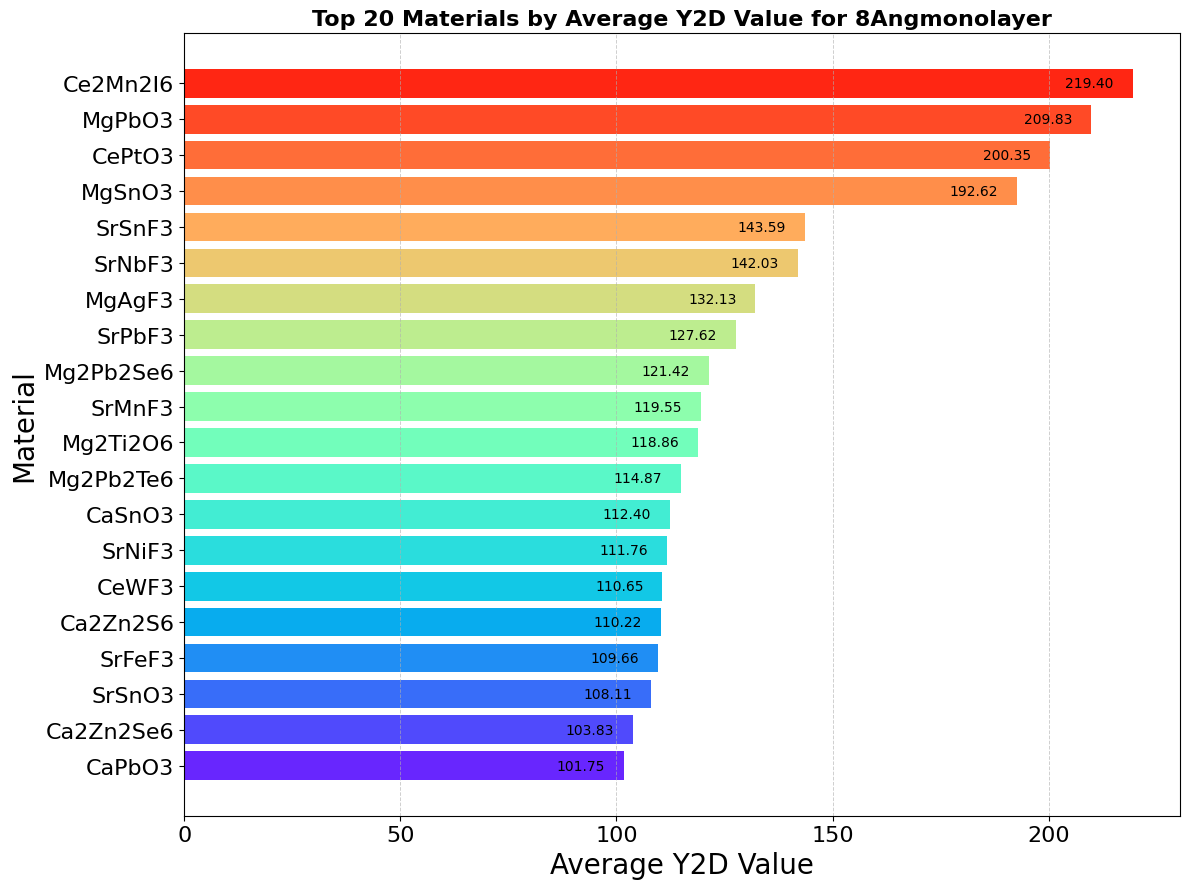

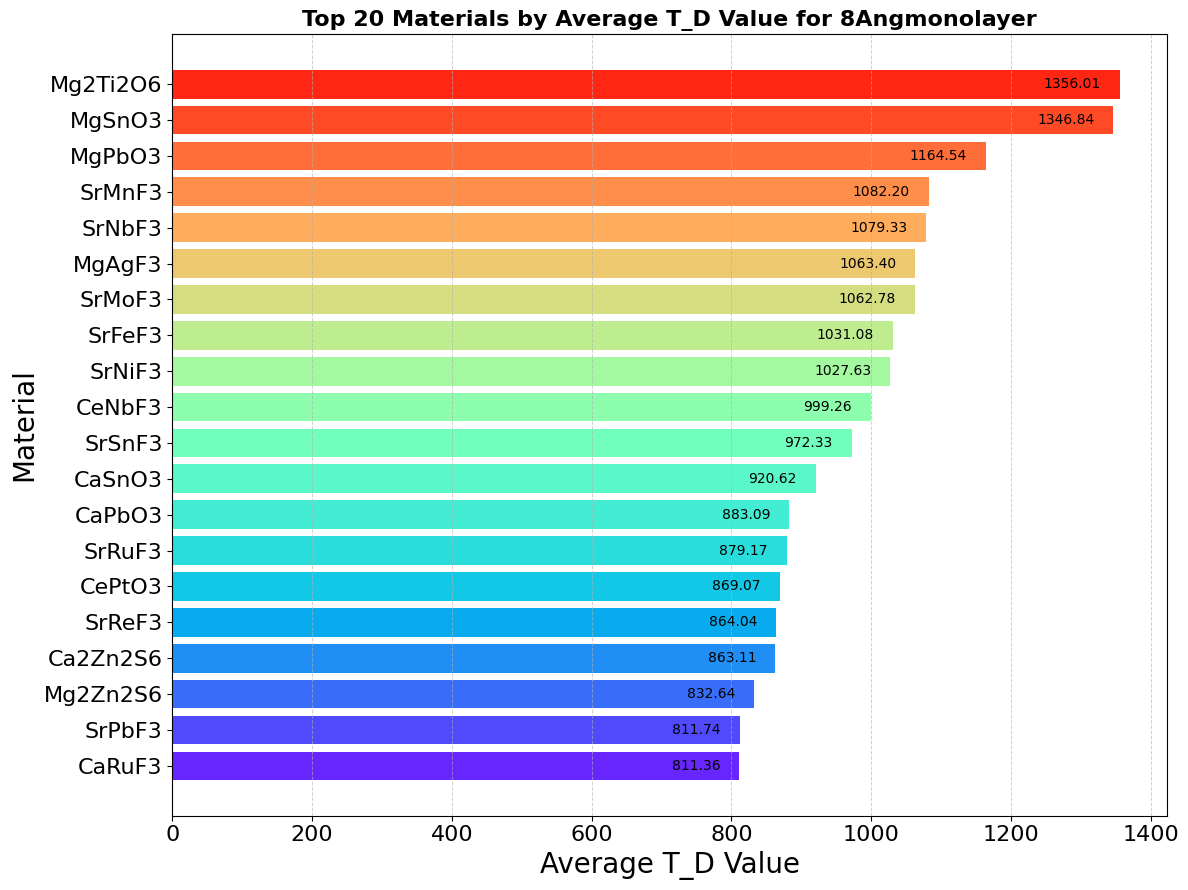

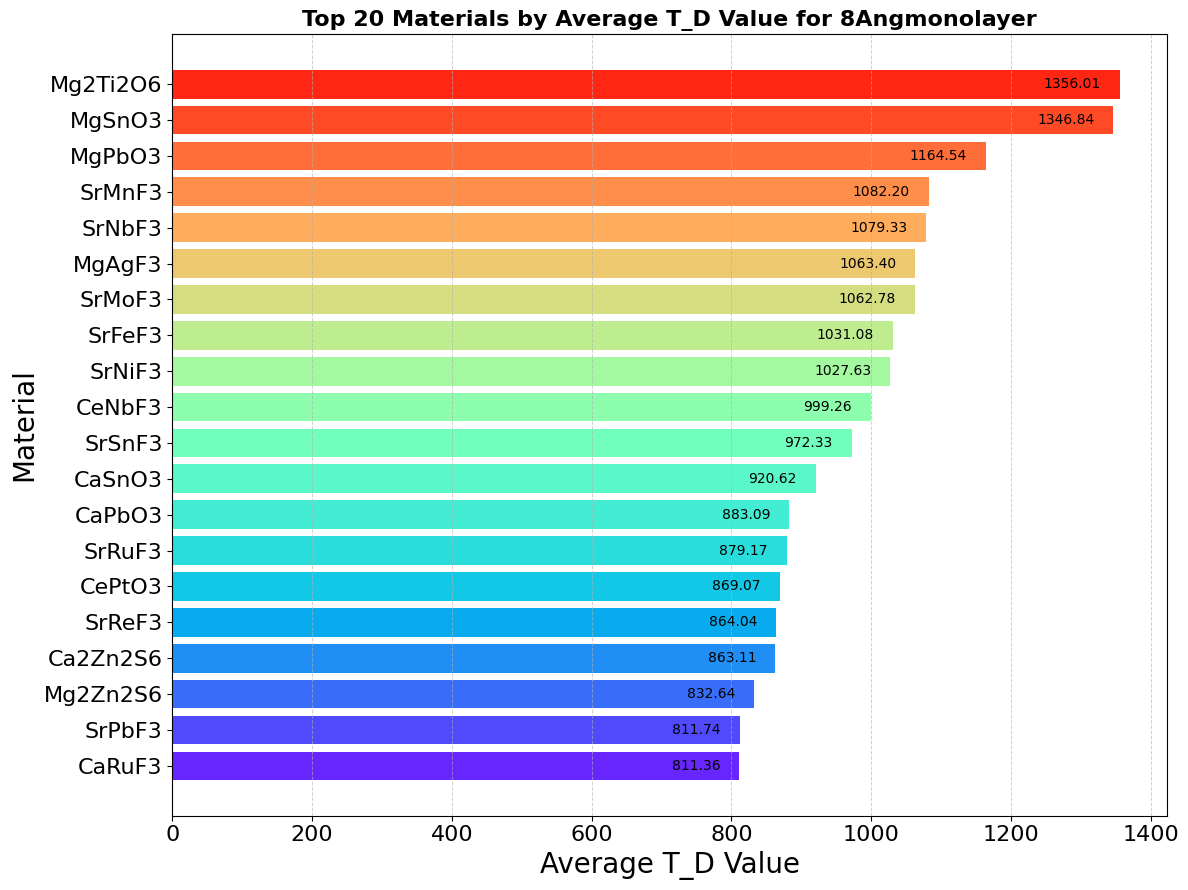

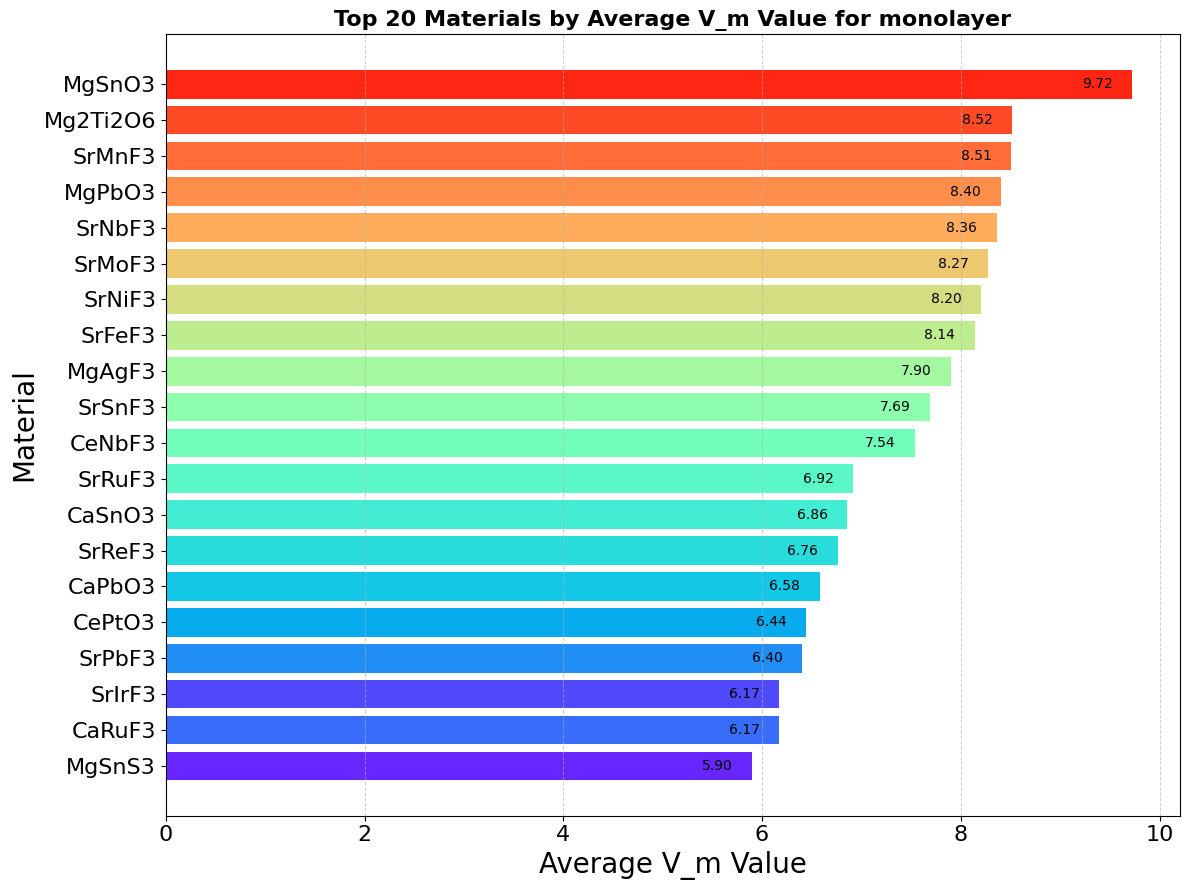

In [10]:
# Visualize some of the trends => EDA
plot_top_materials_by_avg(data, '8Angmonolayer', 'Material', 'Y2D', top_n=20,savplt=savplt)
plot_top_materials_by_avg(data, '8Angmonolayer', 'Material', 'T_D', top_n=20,savplt=savplt)
plot_top_materials_by_avg(data, '8Angmonolayer', 'Material', 'T_D', top_n=20,savplt=True)
plot_top_materials_by_avg(data, 'monolayer', 'Material', 'V_m', top_n=20,savplt=savplt)

In [11]:
unique_count = data.nunique()
print("Number of unique entries in 'combined_8Ang' column:", unique_count)


Number of unique entries in 'combined_8Ang' column: Material      517
WorkFxn       517
mag_moment    403
Bandgap       505
lat_const     473
C11           503
C12           490
Y2D           488
G             457
K             493
v             157
V_l           323
V_s           267
V_m           286
T_D           515
dtype: int64


In [12]:
#Drop all NaN data
data.dropna(inplace=True)

In [13]:
data

,Material,WorkFxn,mag_moment,Bandgap,lat_const,C11,C12,Y2D,G,K,v,V_l,V_s,V_m,T_D
0,Ba2Cr2Cl6,1.708378,8.714,0.1965,6.908,32.30,21.69,17.73,5.30,27.00,0.67,3.69,1.49,1.96,260.70
1,Ba2Mn2F6,1.797230,5.460,0.5112,5.836,40.52,13.35,36.12,13.58,26.93,0.33,3.80,2.20,2.69,424.31
2,Ba2Ti2Cl6,1.868425,4.648,0.4935,7.253,11.56,11.07,0.96,0.25,11.31,0.96,2.33,0.34,0.48,60.29
3,Ba2Mn2Br6,1.908017,8.065,0.1615,7.225,34.53,18.75,24.35,7.89,26.64,0.54,3.30,1.58,2.01,256.11
4,Sr2Mn2Br6,1.982117,8.398,0.2552,7.155,26.28,21.51,8.67,2.38,23.89,0.82,3.03,0.91,1.24,158.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,Mg2Ti2O6,6.676509,0.000,1.8899,5.780,128.62,-35.44,118.86,82.03,46.59,-0.28,9.66,7.71,8.52,1356.01
513,Mg2Ag2Br6,6.786902,0.000,3.0298,7.971,8.06,-3.22,6.78,5.64,2.42,-0.40,1.90,1.59,1.72,198.43
514,Ce2Pb2F6,6.881801,2.242,0.0377,5.674,21.30,3.70,20.66,8.80,12.50,0.17,2.10,1.35,1.61,260.66
515,Mg2Zn2F6,6.936281,0.000,4.9182,6.024,41.28,-10.74,38.49,26.01,15.27,-0.26,5.16,4.10,4.54,692.77


In [14]:
saveplots = False
counts = 20

In [15]:
#Need for analysis save it here before reducing the number of features
select_and_save_materials_flexible_sort(data,'8AngMonoloyer_largerFeature', sort_columns=['WorkFxn', 'mag_moment'], ascending_order=[True, False], count=517, display_columns=['Material', 'WorkFxn', 'mag_moment', 'Bandgap', 'lat_const', 'C11',
       'C12', 'Y2D', 'G', 'K', 'v', 'V_l', 'V_s', 'V_m', 'T_D'], savplt=saveplots)

,Material,WorkFxn,mag_moment,Bandgap,lat_const,C11,C12,Y2D,G,K,v,V_l,V_s,V_m,T_D
0,Ba2Cr2Cl6,1.708378,8.714,0.1965,6.908,32.30,21.69,17.73,5.30,27.00,0.67,3.69,1.49,1.96,260.70
1,Ba2Mn2F6,1.797230,5.460,0.5112,5.836,40.52,13.35,36.12,13.58,26.93,0.33,3.80,2.20,2.69,424.31
2,Ba2Ti2Cl6,1.868425,4.648,0.4935,7.253,11.56,11.07,0.96,0.25,11.31,0.96,2.33,0.34,0.48,60.29
3,Ba2Mn2Br6,1.908017,8.065,0.1615,7.225,34.53,18.75,24.35,7.89,26.64,0.54,3.30,1.58,2.01,256.11
4,Sr2Mn2Br6,1.982117,8.398,0.2552,7.155,26.28,21.51,8.67,2.38,23.89,0.82,3.03,0.91,1.24,158.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,Mg2Ti2O6,6.676509,0.000,1.8899,5.780,128.62,-35.44,118.86,82.03,46.59,-0.28,9.66,7.71,8.52,1356.01
513,Mg2Ag2Br6,6.786902,0.000,3.0298,7.971,8.06,-3.22,6.78,5.64,2.42,-0.40,1.90,1.59,1.72,198.43
514,Ce2Pb2F6,6.881801,2.242,0.0377,5.674,21.30,3.70,20.66,8.80,12.50,0.17,2.10,1.35,1.61,260.66
515,Mg2Zn2F6,6.936281,0.000,4.9182,6.024,41.28,-10.74,38.49,26.01,15.27,-0.26,5.16,4.10,4.54,692.77


In [16]:
# Now we saved on file for analysis. Select subset of the features for our ML and DNN.
selectColmns = ['Material', 'Bandgap', 'WorkFxn', 'lat_const', 'Y2D', 'mag_moment']

In [17]:
data_clean = data[selectColmns]

In [18]:
display(data_clean)

,Material,Bandgap,WorkFxn,lat_const,Y2D,mag_moment
0,Ba2Cr2Cl6,0.1965,1.708378,6.908,17.73,8.714
1,Ba2Mn2F6,0.5112,1.797230,5.836,36.12,5.460
2,Ba2Ti2Cl6,0.4935,1.868425,7.253,0.96,4.648
3,Ba2Mn2Br6,0.1615,1.908017,7.225,24.35,8.065
4,Sr2Mn2Br6,0.2552,1.982117,7.155,8.67,8.398
...,...,...,...,...,...,...
512,Mg2Ti2O6,1.8899,6.676509,5.780,118.86,0.000
513,Mg2Ag2Br6,3.0298,6.786902,7.971,6.78,0.000
514,Ce2Pb2F6,0.0377,6.881801,5.674,20.66,2.242
515,Mg2Zn2F6,4.9182,6.936281,6.024,38.49,0.000


In [19]:
def remove_outliers(df, columns, threshold=3.5):
    """
    Remove outliers from a dataframe for specified columns using the IQR method.

    Parameters:
    - df: pandas DataFrame from which to remove outliers.
    - columns: List of column names to check for outliers.
    - threshold: The multiplier for IQR. Defaults to 1.5 (typical for outlier detection).

    Returns:
    - A new DataFrame with outliers removed from specified columns.
    """
    result = df.copy()

    for column in columns:
        if column in df.columns and (df[column].dtype == 'float64' or df[column].dtype == 'int64'):
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - (threshold * IQR)
            upper_bound = Q3 + (threshold * IQR)
            result = result[(result[column] >= lower_bound) & (result[column] <= upper_bound)]

    return result

In [20]:
if remove_outliers:
  columns_to_check = ['Bandgap']
  # Apply the function to the DataFrame
  data_clean = remove_outliers(data_clean, columns_to_check)

In [21]:
#Let us count the number of unique structures after cleaning
unique_count = data_clean.nunique()
print("Number of unique entries after cleaning data column:", unique_count)

Number of unique entries after cleaning data column: Material      509
Bandgap       497
WorkFxn       509
lat_const     465
Y2D           482
mag_moment    402
dtype: int64


In [22]:
#Look at their correlation map

data_clean.describe().style.background_gradient()

,Bandgap,WorkFxn,lat_const,Y2D,mag_moment
count,509.000000,509.000000,509.000000,509.000000,509.000000
mean,0.716009,4.178573,6.384668,26.638625,1.665183
std,0.750985,0.939883,0.821469,30.906188,1.725875
min,0.000000,1.708378,4.692000,0.030000,-3.324000
25%,0.220800,3.585510,5.755000,8.210000,0.172000
50%,0.389000,4.259159,6.472000,15.780000,1.550000
75%,0.930100,4.781760,6.984000,31.730000,2.497000
max,3.611200,6.953880,8.181000,219.400000,9.118000


In [23]:
#Define a function to process the stiochiometry into a dataframe

def process_dataframe(dfclean, material_column_name):
    # Create Composition objects
    Comp = [Composition(value) for value in dfclean[material_column_name]]
    dfclean.loc[:, 'Composition'] = Comp

    # Featurize the dataframe using ElementFraction
    ef = ElementFraction()
    dfclean = ef.featurize_dataframe(dfclean, 'Composition')
    dfclean = dfclean.loc[:, (dfclean != 0).any(axis=0)]

    # Define the molecular_weight function
    def molecular_weight(formula):
        elements = re.findall(r'([A-Z][a-z]*)(\d*)', formula)
        weight = 0
        for element, count in elements:
            count = int(count) if count else 1
            weight += getattr(periodictable, element).mass * count
        return weight

    # Calculate molecular weights and add them as a new column
    dfclean['MolWeight'] = dfclean[material_column_name].apply(molecular_weight)

    return dfclean

In [24]:
data_clean = process_dataframe(data_clean, 'Material')

ElementFraction:   0%|          | 0/509 [00:00<?, ?it/s]

In [25]:
select_and_save_materials_flexible_sort(data_clean, '8Angmonolayer', sort_columns=['Y2D'], ascending_order=[False], count=counts, display_columns=['Material', "Bandgap", "WorkFxn", "mag_moment", "Y2D"], savplt=saveplots)
select_and_save_materials_flexible_sort(data_clean, '8Angmonolayer', sort_columns=['mag_moment'], ascending_order=[False], count=counts, display_columns=['Material', "Bandgap", "WorkFxn", "mag_moment", "Y2D"], savplt=saveplots)
#Also check large bandgap materials
select_and_save_materials_flexible_sort(data_clean, '8Angmonolayer',  sort_columns=['Bandgap'], ascending_order=[False], count=counts, display_columns=['Material', "Bandgap", "WorkFxn", "mag_moment", "Y2D"], savplt=saveplots)
select_and_save_materials_flexible_sort(data_clean,'8Angmonolayer', sort_columns=['WorkFxn'], ascending_order=[True], count=counts, display_columns=['Material', "Bandgap", "WorkFxn", "mag_moment", "Y2D"], savplt=saveplots)

# Sort low work function and large magnetic moment for the monolayer
select_and_save_materials_flexible_sort(data_clean,'8Angmonolayer', sort_columns=['WorkFxn', 'mag_moment'], ascending_order=[True, False], count=counts, display_columns=['Material', "Bandgap", "WorkFxn", "mag_moment", "Y2D"], savplt=saveplots)

,Material,Bandgap,WorkFxn,mag_moment,Y2D
18,Ce2Mn2I6,0.2069,2.387830,3.387,219.40
237,MgPbO3,1.1640,4.195879,1.858,209.83
195,CePtO3,0.2366,3.944199,1.671,200.35
351,MgSnO3,1.0853,4.626183,1.845,192.62
22,SrSnF3,0.5193,2.616823,0.348,143.59
102,SrNbF3,0.3294,3.330430,2.497,142.03
505,MgAgF3,1.6420,6.033059,0.000,132.13
16,SrPbF3,0.4829,2.327726,0.366,127.62
111,Mg2Pb2Se6,0.1582,3.426008,0.714,121.42
138,SrMnF3,0.9404,3.631466,4.910,119.55


,Material,Bandgap,WorkFxn,mag_moment,Y2D
266,Mg2Mn2Br6,1.6855,4.296585,9.118,19.03
13,Ba2Cr2Br6,0.4619,2.217217,8.898,15.65
0,Ba2Cr2Cl6,0.1965,1.708378,8.714,17.73
4,Sr2Mn2Br6,0.2552,1.982117,8.398,8.67
14,Ba2Mn2I6,0.0277,2.231895,8.075,15.76
3,Ba2Mn2Br6,0.1615,1.908017,8.065,24.35
12,Ba2V2Br6,0.7821,2.163344,6.717,9.72
275,Mg2Cr2Te6,0.0671,4.325060,6.648,3.39
469,Ca2Cr2Se6,0.3195,5.434810,6.087,9.69
317,Ca2Fe2O6,0.2300,4.484154,5.712,36.42


,Material,Bandgap,WorkFxn,mag_moment,Y2D
421,BaSnO3,3.6112,5.032920,0.000,8.21
466,BaFeO3,3.5895,5.417071,1.914,12.93
459,Sr2Cu2Cl6,3.5406,5.340501,0.000,6.50
468,Sr2Cu2Br6,3.3216,5.428676,0.000,7.03
313,BaVO3,3.2666,4.468367,0.732,21.19
496,Ca2Cu2Br6,3.2212,5.700191,0.000,2.45
488,Ca2Cu2Cl6,3.2164,5.575232,0.000,10.43
516,Mg2Ag2Cl6,3.2080,6.953880,0.000,16.66
242,BaMoO3,3.2075,4.207365,0.000,14.14
261,BaCuCl3,3.1777,4.279094,0.000,7.84


,Material,Bandgap,WorkFxn,mag_moment,Y2D
0,Ba2Cr2Cl6,0.1965,1.708378,8.714,17.73
1,Ba2Mn2F6,0.5112,1.797230,5.460,36.12
2,Ba2Ti2Cl6,0.4935,1.868425,4.648,0.96
3,Ba2Mn2Br6,0.1615,1.908017,8.065,24.35
4,Sr2Mn2Br6,0.2552,1.982117,8.398,8.67
5,BaNiCl3,0.7718,2.014044,1.051,14.30
6,Ba2V2Cl6,0.2517,2.051915,4.340,10.02
7,Ba2Fe2F6,1.3050,2.071828,2.471,32.90
8,Ba2Ti2Br6,0.2804,2.124089,4.738,5.44
9,BaPbF3,0.5407,2.135703,0.350,42.43


,Material,Bandgap,WorkFxn,mag_moment,Y2D
0,Ba2Cr2Cl6,0.1965,1.708378,8.714,17.73
1,Ba2Mn2F6,0.5112,1.797230,5.460,36.12
2,Ba2Ti2Cl6,0.4935,1.868425,4.648,0.96
3,Ba2Mn2Br6,0.1615,1.908017,8.065,24.35
4,Sr2Mn2Br6,0.2552,1.982117,8.398,8.67
5,BaNiCl3,0.7718,2.014044,1.051,14.30
6,Ba2V2Cl6,0.2517,2.051915,4.340,10.02
7,Ba2Fe2F6,1.3050,2.071828,2.471,32.90
8,Ba2Ti2Br6,0.2804,2.124089,4.738,5.44
9,BaPbF3,0.5407,2.135703,0.350,42.43


In [26]:
def plot_property_vs_property(data, tagname, save_path=None, figsize=(12, 8)):
    """
    Plots Bandgap vs Y_2D with point sizes indicating the work function.

    Parameters:
    - data (DataFrame): The dataset containing the columns 'Bandgap', 'Y2D', and 'WorkFxn'.
    - save_path (str, optional): The directory where the plot will be saved. If None, the plot won't be saved.
    - file_name (str): The name of the file when saving the plot.
    - figsize (tuple): Figure size in inches.

    Returns:
    - None. Displays the plot.
    """

    # Create the scatter plot
    plt.figure(figsize=figsize)
    plt.scatter(data['Bandgap'],
                data['Y2D'],
                s=data['WorkFxn']*20,  # Scaling the size for better visualization
                c=data['WorkFxn'],
                cmap="nipy_spectral_r",  # This colormap is visually similar to "Picnic"
                alpha=0.6,
                edgecolors="w", linewidth=0.5)
    plt.title('Scatter plot of Bandgap vs Y_2D with point size indicating work function', fontsize=15)
    plt.xlabel('Bandgap (eV)', fontsize=18)
    plt.ylabel("Young's modulus (N/m)", fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()

    # Add a colorbar to represent the work function values
    cbar = plt.colorbar()
    cbar.set_label('Mean Work Function', size=12)
    cbar.ax.tick_params(labelsize=10)

    # Save the plot if save_path is provided
    if save_path:
        file_name=f"{tagname}_bandgap_vs_y2d.png"
        full_path = os.path.join(save_path, file_name)
        plt.savefig(full_path, dpi=400, bbox_inches='tight')

    # Display the plot
    plt.show()


In [27]:
# Define a function to plot the parameters. This will use plotly for interactive access. Same as above, but it is interactive

import os
import plotly.express as px
import plotly.io as pio

def plot_material_properties(data, tagname, save_path=None):
    """
    Plots material properties using Plotly.

    Parameters:
    - data (DataFrame): The dataset containing material properties.
    - save_path (str, optional): The directory where the plot will be saved. If None, the plot won't be saved.

    Returns:
    - None. Displays the plot.
    """

    # Create a scatter plot using Plotly Express
    fig = px.scatter(data,
                     x='Bandgap',
                     y='Y2D',
                     color='WorkFxn',
                     color_continuous_scale='Picnic',
                     text=data['Material'])

    # Update trace for text positioning
    fig.update_traces(textposition='top center')

    # Customize the layout
    fig.update_layout(
        title_text='Material Properties',
        yaxis=dict(
            title="Young's modulus (N/m)",
            titlefont=dict(size=18),  # Font size for the y-axis title
            tickfont=dict(size=14),   # Font size for the y-axis ticks
            showgrid=False,
            showline=True,
            linewidth=2,
            linecolor='black',
            ticks="outside",
            mirror=True,
            ticklen=8
        ),
        xaxis=dict(
            title="Bandgap (eV)",
            titlefont=dict(size=18),  # Font size for the x-axis title
            tickfont=dict(size=14),   # Font size for the x-axis ticks
            showgrid=False,
            showline=True,
            linewidth=2,
            linecolor='black',
            ticks="outside",
            mirror=True,
            ticklen=8
        ),
        plot_bgcolor='rgba(255, 255, 255, 0.0)'
    )

    # Display the plot
    fig.show(renderer='colab')

    # Save the plot if save_path is provided
    if save_path:
        file_name = f'{tagname}_bandgap_y2d_plot.png'
        full_path = os.path.join(save_path, file_name)
        pio.write_image(fig, full_path)

In [28]:
#3D surface plot
import numpy as np
import plotly.graph_objects as go
from scipy.interpolate import griddata

def plot_3d_surface(data, x_col, y_col, z_col, font_size=12, title="3D Surface Plot",
                    save_path="3D_surface_plot.png", width=800, height=600):
    """
    Generate a 3D surface plot and save it as a PNG.

    Args:
    - data (pd.DataFrame): Data containing the columns to plot.
    - x_col (str): Name of the column for the x-axis.
    - y_col (str): Name of the column for the y-axis.
    - z_col (str): Name of the column for the z-axis.
    - font_size (int): Font size for the plot title and axis labels.
    - title (str): Title for the plot.
    - save_path (str): Path to save the PNG.
    - width (int): Width of the saved image.
    - height (int): Height of the saved image.

    Returns:
    - None: Saves the plot and shows it.
    """
    # Extract data
    x = data[x_col].values
    y = data[y_col].values
    z = data[z_col].values

    # Create a grid of values
    xi = np.linspace(x.min(), x.max(), 100)
    yi = np.linspace(y.min(), y.max(), 100)
    xi, yi = np.meshgrid(xi, yi)
    zi = griddata((x, y), z, (xi, yi), method='cubic')

    # Create the 3D surface plot
    fig = go.Figure(data=[go.Surface(z=zi, x=xi, y=yi, colorscale='Viridis', cmin=z.min(), cmax=z.max())])

    fig.update_layout(scene=dict(zaxis=dict(title=z_col, mirror=True,titlefont_size=font_size, ticks='outside',
                                            showline=True,gridcolor='lightgrey', tickfont_size=font_size,tickfont=dict(size=14), showgrid=True,
                                            backgroundcolor='white',showticklabels=True,linecolor='black',linewidth=2),
                                 xaxis=dict(title=x_col, mirror=True,titlefont_size=font_size, tickfont_size=font_size,
                                            showgrid=True, backgroundcolor='white',showticklabels=True,
                                            linecolor='black',    ticks='outside', showline=True,gridcolor='lightgrey',linewidth=2,tickfont=dict(size=14)),
                                 yaxis=dict(title=y_col, mirror=True,titlefont_size=font_size, tickfont_size=font_size,
                                                ticks='outside', showline=True,gridcolor='lightgrey',linecolor='black',linewidth=2,
                                                showgrid=True, backgroundcolor='white',tickfont=dict(size=14),showticklabels=True)),
                      title=dict(text=title, font=dict(size=font_size)),
                      font=dict(size=font_size),
                      width=width, height=height,
                      margin=dict(t=40, b=40, l=60, r=60))

    fig.update_layout(
        scene=dict(
            xaxis=dict(showticklabels=True),
            yaxis=dict(showticklabels=True),
            zaxis=dict(showticklabels=True),
        )
    )
    fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                    highlightcolor="limegreen", project_z=True))

    fig.show()

    # Save the figure
    fig.write_image(save_path, scale=5)  # scale factor to increase resolution


In [29]:
plot_material_properties(data_clean, '8AngMonolayer', save_path=dataplots)

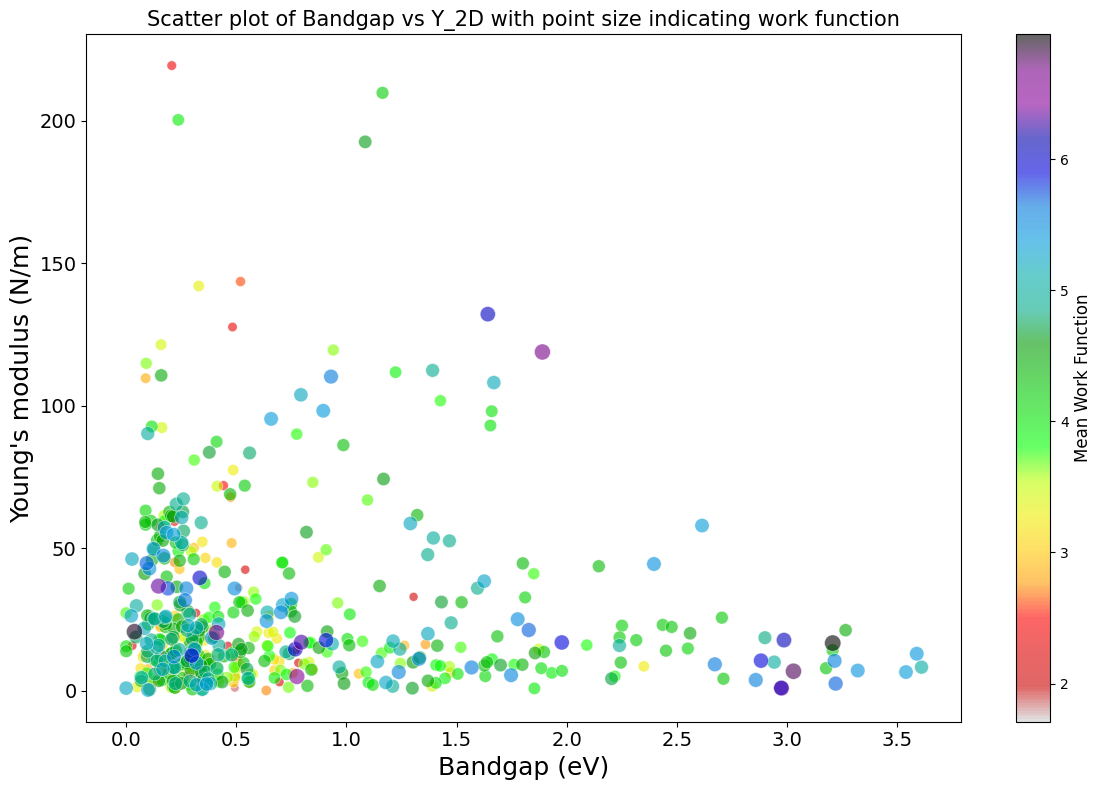

In [30]:
plot_property_vs_property(data_clean, 'ordinary_8AngMonolayer', save_path=dataplots)

In [31]:


# Use the function
plot_3d_surface(data_clean, 'Y2D', 'lat_const', 'Bandgap', font_size=22,
                title="3D Surface Plot of Bandgap vs. Young's modulus and lattice constant",
                save_path=f"{dataplots}/3D_surface_plot_Y2D_a_Eg.png", width=1000, height=800)

In [32]:
data_clean.drop(columns=['Composition', 'Material'], inplace=True) #,'MolWeight'

In [33]:
# Scale the features before the ML modeling
scaler = StandardScaler()

X = data_clean.drop(columns=['lat_const','WorkFxn','mag_moment','Bandgap','Y2D'],axis=1)
y = data_clean['lat_const']
columns=X.columns
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

mattype = "8Ang_monolayer"

In [34]:
X_train , X_test , y_train , y_test = train_test_split(X_scaled_df , y, test_size=test_size,random_state=rndseem) #stratify=y_binned

hyper_params_lgbm = {
    "objective" : "multiclass",
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'n_estimators': 1000,
    "verbosity" : -1
}

hyper_params_xgb = {
    'objective': 'reg:squarederror',
    'n_estimators': 1000,
    'eval_metric': mean_absolute_error
    }

MLA = [
    RandomForestRegressor(),
    BayesianRidge(),
    LinearRegression(),
    KNeighborsRegressor(),
    LassoLars(alpha=0.01,max_iter=1000,eps=1e-5),
    LassoLarsCV(),
    ARDRegression(),
    svm.LinearSVR(max_iter=1500000),
    svm.SVR(max_iter=1500000),
    svm.NuSVR(max_iter=1500000),
    PLSRegression(n_components=2),
    DecisionTreeRegressor(),
    ExtraTreeRegressor(),
    XGBRFRegressor(**hyper_params_xgb),
    LGBMRegressor(**hyper_params_lgbm),
    AdaBoostRegressor(),
    GradientBoostingRegressor(),
    ExtraTreesRegressor(),
    CatBoostRegressor(loss_function='RMSE')
]


col = []
algorithms = pd.DataFrame(columns = col)
idx = 0

best_model = None
best_score = -float('inf')

#Train and score algorithms
#cv = RepeatedKFold(n_splits=10, n_repeats=5,random_state=rndseem) #Apply cross-validation
cv = ShuffleSplit(n_splits = 10, test_size = test_size+0.1, random_state = rndseem)

for model in MLA:
    try:
        Alg = model.__class__.__name__
        if Alg == 'LGBMRegressor' or Alg == 'XGBRFRegressor':
            model.fit(X_train, y_train,eval_set=[(X_test, y_test)])
        else:
            model.fit(X_train, y_train)
        cross_validation = cross_val_score(model, X_train, y_train, cv  = cv, scoring='r2')
        mean_cv_score = cross_validation.mean()
        pred        = model.predict(X_test)
        adj_R2      = 1 - (1-model.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
        Train_Score = model.score(X_train, y_train)
        Test_Score  = model.score(X_test, y_test)
        MSE         = metrics.mean_squared_error(y_test, pred)
        MAE         = metrics.mean_absolute_error(y_test, pred)
        MAPE        = metrics.mean_absolute_percentage_error(y_test, pred)*100
        STD         = cross_validation.std()

        if mean_cv_score > best_score:
            best_score = mean_cv_score
            best_model = model

        algorithms.loc[idx, 'Algorithm'] = Alg

        algorithms.loc[idx, 'Model-Sc'] = round(Train_Score* 100,2)
        algorithms.loc[idx, 'Adj-Sc']  = round(adj_R2* 100, 2)
        algorithms.loc[idx, 'Test-Sc']   = round(Test_Score* 100, 2)
        algorithms.loc[idx, 'CV-Sc'] = round(cross_validation.mean()* 100, 2)
        algorithms.loc[idx, 'MSE']   = round(MSE, 2)
        algorithms.loc[idx, 'MAE']   = round(MAE, 2)
        #algorithms.loc[idx, 'MAPE']   = round(MAPE, 2)
        algorithms.loc[idx, 'STD']   = round(STD, 2)

        CV_Score = pd.DataFrame({'CV-Scores for '+Alg: cross_validation})
        idx+=1
        display(CV_Score)
    except Exception as e:
        print(f"Exception occurred in {str(e)}")
        pass

import joblib

if best_model is not None:
    joblib.dump(best_model, dataplots+f'/best_model_{mattype}.pkl')

,CV-Scores for RandomForestRegressor
0,0.858547
1,0.812190
2,0.799718
3,0.825089
4,0.753965
5,0.816711
6,0.871709
7,0.865567
8,0.844888
9,0.780309


,CV-Scores for BayesianRidge
0,0.856666
1,0.798247
2,0.750092
3,0.774634
4,0.739161
5,0.816583
6,0.801408
7,0.805748
8,0.779506
9,0.763812


,CV-Scores for LinearRegression
0,0.855819
1,0.796763
2,0.747679
3,0.768267
4,0.738132
5,0.816448
6,0.798360
7,0.806630
8,0.765026
9,0.763531


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:794: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_regression.py", line 248, in predict
    y_pred = np.mean(_y[neigh_ind], axis=1)
IndexError: index 4294967297 is out of bounds for axis 0 with size 284


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_val

Exception occurred in index 4294967297 is out of bounds for axis 0 with size 407


,CV-Scores for LassoLars
0,0.852037
1,0.793732
2,0.750426
3,0.784193
4,0.737070
5,0.817484
6,0.812033
7,0.797844
8,0.779938
9,0.771549


,CV-Scores for LassoLarsCV
0,0.855563
1,0.797038
2,0.750034
3,0.781249
4,0.736372
5,0.817835
6,0.812049
7,0.802123
8,0.779658
9,0.767560


,CV-Scores for ARDRegression
0,0.848081
1,0.790115
2,0.753288
3,0.770410
4,0.735473
5,0.815290
6,0.806425
7,0.792178
8,0.782614
9,0.771378


,CV-Scores for LinearSVR
0,0.861052
1,0.780746
2,0.746268
3,0.773697
4,0.736188
5,0.797257
6,0.781743
7,0.793117
8,0.765407
9,0.740284


,CV-Scores for SVR
0,0.857858
1,0.816539
2,0.806658
3,0.805247
4,0.750473
5,0.825498
6,0.828412
7,0.853315
8,0.794797
9,0.793038


,CV-Scores for NuSVR
0,0.863467
1,0.818692
2,0.813025
3,0.811010
4,0.756464
5,0.829963
6,0.832398
7,0.854485
8,0.796774
9,0.799264


,CV-Scores for PLSRegression
0,0.870706
1,0.795833
2,0.756716
3,0.771140
4,0.736170
5,0.815959
6,0.794111
7,0.801122
8,0.775586
9,0.763920


,CV-Scores for DecisionTreeRegressor
0,0.782173
1,0.722851
2,0.697366
3,0.748330
4,0.624167
5,0.691427
6,0.792713
7,0.793356
8,0.696149
9,0.747196


,CV-Scores for ExtraTreeRegressor
0,0.804760
1,0.705786
2,0.761653
3,0.670878
4,0.714314
5,0.768108
6,0.794897
7,0.762176
8,0.778346
9,0.722862


[0]	validation_0-rmse:0.34253	validation_0-mean_absolute_error:0.26511


,CV-Scores for XGBRFRegressor
0,0.823280
1,0.747745
2,0.732935
3,0.780284
4,0.692299
5,0.790399
6,0.816575
7,0.772249
8,0.758134
9,0.733231


,CV-Scores for LGBMRegressor
0,0.792878
1,0.752256
2,0.723946
3,0.792000
4,0.633417
5,0.752827
6,0.802340
7,0.729322
8,0.716770
9,0.744868


,CV-Scores for AdaBoostRegressor
0,0.676351
1,0.650741
2,0.671826
3,0.707346
4,0.618956
5,0.689881
6,0.751357
7,0.674351
8,0.715371
9,0.715928


,CV-Scores for GradientBoostingRegressor
0,0.866260
1,0.813535
2,0.794330
3,0.833117
4,0.768898
5,0.852595
6,0.871609
7,0.836149
8,0.806708
9,0.769526


,CV-Scores for ExtraTreesRegressor
0,0.814091
1,0.805132
2,0.786235
3,0.773971
4,0.763971
5,0.820586
6,0.831954
7,0.812697
8,0.814795
9,0.789261


Streaming output truncated to the last 5000 lines.
4:	learn: 0.7393912	total: 9.29ms	remaining: 1.85s
5:	learn: 0.7268524	total: 11ms	remaining: 1.82s
6:	learn: 0.7146851	total: 13ms	remaining: 1.85s
7:	learn: 0.7055120	total: 14.4ms	remaining: 1.79s
8:	learn: 0.6933567	total: 15.2ms	remaining: 1.68s
9:	learn: 0.6857990	total: 16.2ms	remaining: 1.6s
10:	learn: 0.6751090	total: 17.1ms	remaining: 1.54s
11:	learn: 0.6645702	total: 18.4ms	remaining: 1.52s
12:	learn: 0.6528238	total: 20.4ms	remaining: 1.55s
13:	learn: 0.6414147	total: 21.8ms	remaining: 1.54s
14:	learn: 0.6334703	total: 22.7ms	remaining: 1.49s
15:	learn: 0.6239986	total: 24.1ms	remaining: 1.48s
16:	learn: 0.6154300	total: 25.3ms	remaining: 1.46s
17:	learn: 0.6069298	total: 26.6ms	remaining: 1.45s
18:	learn: 0.5983378	total: 27.6ms	remaining: 1.42s
19:	learn: 0.5909576	total: 28.7ms	remaining: 1.41s
20:	learn: 0.5825707	total: 30.1ms	remaining: 1.4s
21:	learn: 0.5756339	total: 32.6ms	remaining: 1.45s
22:	learn: 0.5678190	tota

,CV-Scores for CatBoostRegressor
0,0.874203
1,0.844526
2,0.828812
3,0.841135
4,0.767977
5,0.864219
6,0.879404
7,0.883569
8,0.845347
9,0.826095


In [35]:
algorithms

,Algorithm,Model-Sc,Adj-Sc,Test-Sc,CV-Sc,MSE,MAE,STD
0,RandomForestRegressor,98.07,97.90,89.61,82.29,0.08,0.20,0.04
1,BayesianRidge,82.41,80.86,87.81,78.86,0.09,0.23,0.03
2,LinearRegression,82.13,80.55,87.76,78.57,0.09,0.23,0.03
3,LassoLars,81.99,80.39,87.54,78.96,0.09,0.24,0.03
4,LassoLarsCV,82.44,80.89,87.89,78.99,0.09,0.23,0.03
5,ARDRegression,81.99,80.39,87.87,78.65,0.09,0.23,0.03
6,LinearSVR,80.92,79.23,87.35,77.76,0.09,0.23,0.03
7,SVR,95.58,95.19,90.34,81.32,0.07,0.21,0.03
8,NuSVR,95.92,95.56,90.92,81.76,0.07,0.20,0.03
9,PLSRegression,81.97,80.38,87.04,78.81,0.10,0.24,0.04


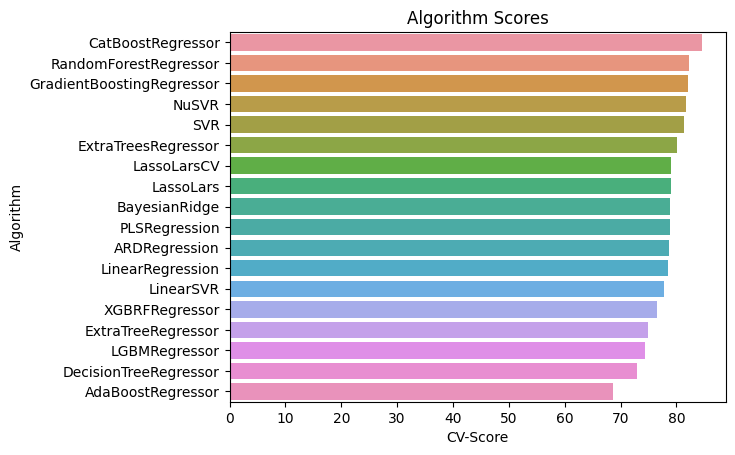

In [36]:
# Sort the DataFrame by "CV-Sc" in descending order
algorithms = algorithms.sort_values(by="CV-Sc", ascending=False)

# Create the bar plot
ax = sns.barplot(x="CV-Sc", y="Algorithm", data=algorithms, order=algorithms["Algorithm"])
ax.set_xlabel("CV-Score")
ax.set_title("Algorithm Scores")

if savplt:
  plt.savefig(dataplots+f'/algorithm_cv_scores_{mattype}.png', dpi=400, bbox_inches='tight')
# Show the plot
plt.show()

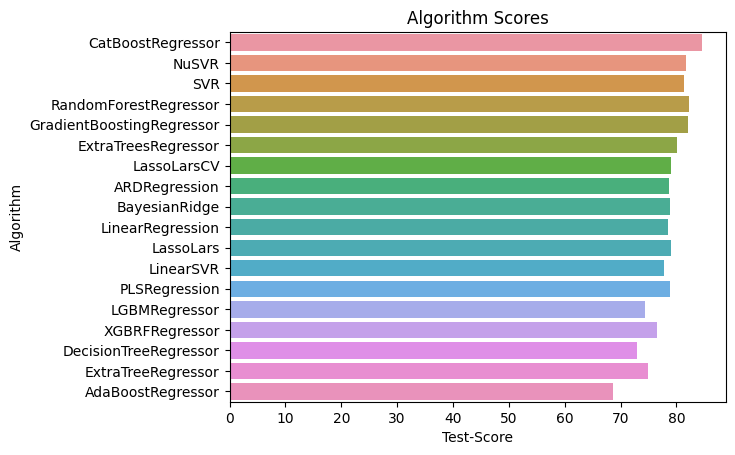

In [37]:
# Sort the DataFrame by "CV-Sc" in descending order
algorithms = algorithms.sort_values(by="Test-Sc", ascending=False)
# Create the bar plot
ax = sns.barplot(x="CV-Sc", y="Algorithm", data=algorithms, order=algorithms["Algorithm"])
ax.set_xlabel("Test-Score")
ax.set_title("Algorithm Scores")

if savplt:
  plt.savefig(dataplots+f'/algorithm_test_scores_{mattype}.png', dpi=400, bbox_inches='tight')
# Show the plot
plt.show()

In [38]:
#Define colors for the features
feature_colors = ['red', 'blue', 'green', 'orange', 'purple', 'pink', 'cyan', 'indigo', 'lime', 'maroon', 'navy', 'olive', 'teal', 'aqua', 'fuchsia', 'gold', 'silver', 'darkred', 'darkblue', 'darkgreen', 'lightblue', 'lightgreen', 'coral', 'beige', 'chocolate', 'orchid']
# List of colors for each feature (customize as needed)
def get_color_list(num_features):
    return [color for _, color in zip(range(num_features), itertools.cycle(feature_colors))]

num_features = len(X_test.columns)
feature_colors = get_color_list(num_features)

Result for CatBoostRegressor


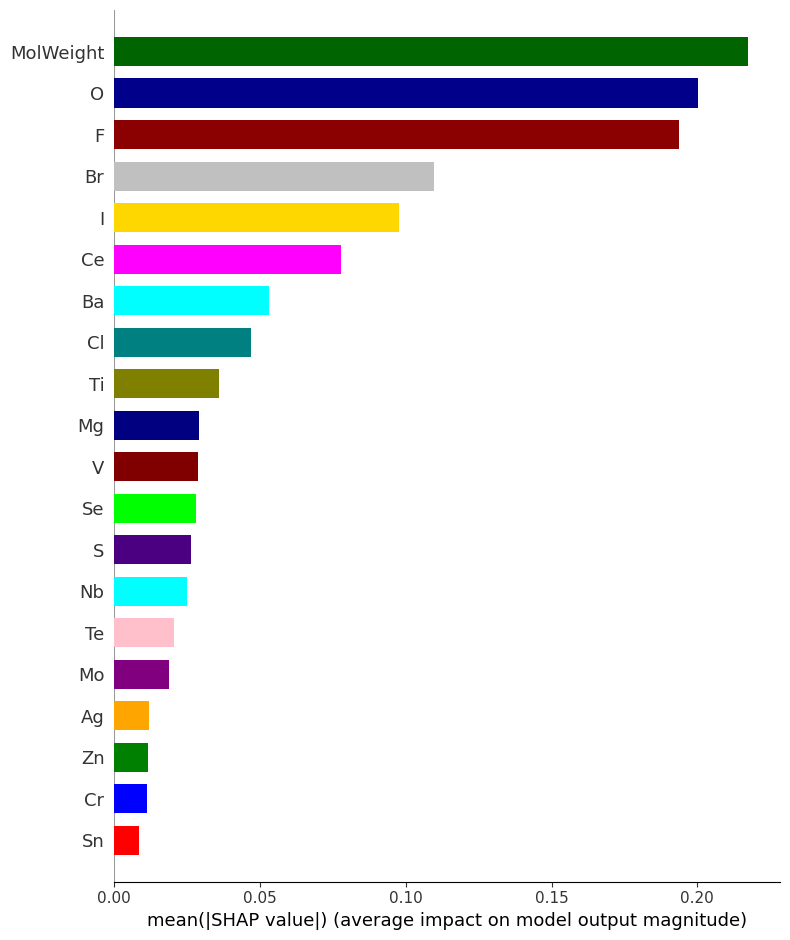

In [39]:
# Load the best model from the saved file
best_model = joblib.load(dataplots+f'/best_model_{mattype}.pkl')  # Update the file path accordingly

try:
    Alg = best_model.__class__.__name__
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_test)
    print('Result for', Alg)
    #print(shap_values)

    # Create a summary plot with custom feature colors
    shap.summary_plot(shap_values, X_test, plot_type="bar", color=feature_colors,show=False)
    if savplt:
      plt.savefig(dataplots+f'/shap_feature_importance_summary_plot_{mattype}.png', dpi=400, bbox_inches='tight')
    plt.show()  # Display the plot
except Exception as e:
    print(f"Exception occurred in {str(e)}")
    pass

In [40]:
def calculate_iqr_bounds(values, factor=1.5):
    """
    Calculate bounds based on the IQR to exclude outliers.

    Parameters:
    - values: The data values to calculate the IQR for.
    - factor: The multiplier for the IQR to define what is considered an outlier.

    Returns:
    - A tuple containing the lower and upper bounds.
    """
    Q1, Q3 = np.percentile(values, [25, 75])
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    return lower_bound, upper_bound

def plot_predicted_vs_actual(y_test, best_predictions, R2_value, MSE, mattype, save_plot=False):
    """
    Plot the predicted vs actual values with automatic bounds to exclude outliers.

    Parameters:
    - y_test: The actual values.
    - best_predictions: The predicted values by the model.
    - R2_value: The R^2 value of the model.
    - MSE: The mean squared error of the model.
    - mattype: The type of material, used in naming the saved plot.
    - dataplots: The path to save the plot.
    - save_plot: A boolean indicating whether to save the plot or not.
    """
    # Determine the plot bounds based on both actual and predicted values
    lower_bound_y, upper_bound_y = calculate_iqr_bounds(y_test)
    lower_bound_pred, upper_bound_pred = calculate_iqr_bounds(best_predictions)

    # Use the larger of the two ranges to ensure the plot is square
    lower_bound = min(lower_bound_y, lower_bound_pred)
    upper_bound = max(upper_bound_y, upper_bound_pred)

    # Plotting the predicted vs actual values
    f, ax = plt.subplots(figsize=(8, 8))
    plt.plot(y_test, best_predictions, 'o', color="green")
    plt.ylabel(r"$a_{predicted}$ ($\AA$)", fontsize=18)
    plt.xlabel(r"$a$ ($\AA$)", fontsize=18)
    plt.xlim([lower_bound, upper_bound])
    plt.ylim([lower_bound, upper_bound])
    plt.plot([lower_bound, upper_bound], [lower_bound, upper_bound], 'k--')
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.annotate(r"$R^2$ = %.2f, MSE = %.3f" % (R2_value, MSE), (lower_bound + 0.1 * (upper_bound - lower_bound), upper_bound - 0.1 * (upper_bound - lower_bound)), fontsize=18)

    if save_plot:
        plt.savefig(dataplots+f"/best_model_plot_latconst_actual_vs_predicted_{mattype}.png", dpi=400, bbox_inches='tight')

    plt.show()

MSE for the best model: 0.05
R^2 for the best model: 0.9285


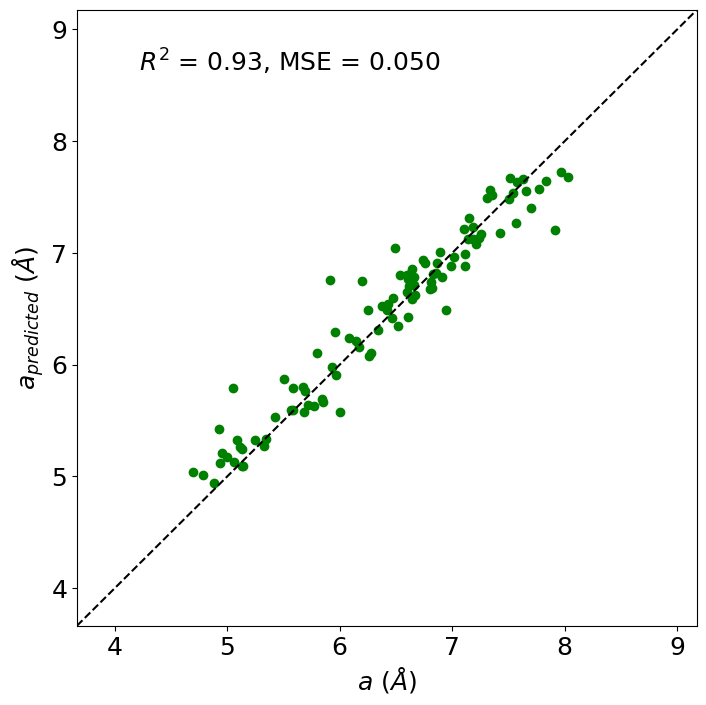

In [41]:
# Get the metrics for the best model from the dataframe
best_row = algorithms[algorithms['Algorithm'] == best_model.__class__.__name__].iloc[0]

# Get predictions from the best model
best_predictions = best_model.predict(X_test)

# Extract the R^2 and MSE values for the best model
R2_value = best_row['Test-Sc'] / 100  # converting percentage to fraction
MSE = best_row['MSE']

# Printing them for reference
print(f"MSE for the best model: {MSE}")
print(f"R^2 for the best model: {R2_value}")



plot_predicted_vs_actual(y_test, best_predictions, R2_value, MSE, mattype=mattype, save_plot=True)

In [42]:
print(best_model.__class__.__name__)

CatBoostRegressor


In [43]:
if hyperparameter:


  import time
  from sklearn.model_selection import RepeatedKFold, RandomizedSearchCV
  import joblib

  # Directly obtain the best model from above
  model_name = best_model.__class__.__name__
  class HyperparameterTuning:
      def __init__(self, model, parameters, X_train, y_train, random_seed=rndseem, n_iter=10, n_jobs=-1, save_model_path=None):
          self.model = model
          self.parameters = parameters
          self.X_train = X_train
          self.y_train = y_train
          self.random_seed = rndseem
          self.n_iter = n_iter
          self.save_model_path = save_model_path
          self.n_jobs = n_jobs

      def train_and_tune(self):
          timet = time.time()

          # Define the number of folds
          #folds = RepeatedKFold(n_splits=10, n_repeats=10, random_state=self.random_seed)
          folds = ShuffleSplit(n_splits = 10, test_size = test_size+0.1, random_state = rndseem)


          # Define the RandomizedSearchCV
          gsc = RandomizedSearchCV(
              estimator=self.model,
              param_distributions=self.parameters,
              n_iter=self.n_iter,
              #n_jobs=-1,
              random_state=self.random_seed,
              return_train_score=True,
              cv=folds
          )

          grid_result = gsc.fit(self.X_train, self.y_train)

          print(f'Time for hyperparameter tuning for the best ML model is: {time.time() - timet}')

          # Save the best model if save_model_path is provided
          if self.save_model_path:
              best_model = grid_result.best_estimator_
              joblib.dump(best_model, self.save_model_path)

          return grid_result


  bestmodel_tmp = eval(model_name + '()') #CatBoostRegressor()

  if model_name == 'ExtraTreesRegressor':
      parameters = {
          'n_estimators': [50, 100, 200],
          'max_depth': [None, 10, 20, 30],
          'min_samples_split': [2, 5, 10],
          'min_samples_leaf': [1, 2, 4],
          'max_features': [1, 'sqrt','log2']
      }
  elif model_name == 'LassoLars':
    parameters = {
      'alpha': [0.1, 0.01, 0.001],  # Regularization strength
      'max_iter': [500, 1000, 1500],         # Maximum number of iterations
      'fit_intercept': [True, False]        # Whether to fit the intercept
          }
  else:
      parameters = {
          'depth': [8, 10, 12],
          'learning_rate': [0.01, 0.02],
          'iterations': [200, 1000],
          'loss_function': ['RMSE','MAE']
      }

  save_model_path = dataplots+f'/best_model_hyperparameter_{mattype}.pkl'

  hyperparameter_tuner = HyperparameterTuning(bestmodel_tmp, parameters, X_train, y_train, n_jobs = -1, save_model_path=save_model_path)
  grid_result = hyperparameter_tuner.train_and_tune()

  # Get the best hyperparameters and best model
  best_params = grid_result.best_params_
  best_model = grid_result.best_estimator_

Streaming output truncated to the last 5000 lines.
1:	learn: 0.8186186	total: 6.06ms	remaining: 3.02s
2:	learn: 0.8142224	total: 12.8ms	remaining: 4.25s
3:	learn: 0.8096848	total: 16.1ms	remaining: 4s
4:	learn: 0.8050072	total: 24.7ms	remaining: 4.91s
5:	learn: 0.8008427	total: 36.1ms	remaining: 5.98s
6:	learn: 0.7957655	total: 43.8ms	remaining: 6.21s
7:	learn: 0.7913360	total: 47.6ms	remaining: 5.9s
8:	learn: 0.7870973	total: 55.7ms	remaining: 6.13s
9:	learn: 0.7831821	total: 67.5ms	remaining: 6.68s
10:	learn: 0.7787288	total: 71.6ms	remaining: 6.44s
11:	learn: 0.7743438	total: 73.9ms	remaining: 6.08s
12:	learn: 0.7701452	total: 75.4ms	remaining: 5.72s
13:	learn: 0.7671467	total: 83.2ms	remaining: 5.86s
14:	learn: 0.7637748	total: 95.5ms	remaining: 6.27s
15:	learn: 0.7591006	total: 99.3ms	remaining: 6.11s
16:	learn: 0.7556820	total: 108ms	remaining: 6.27s
17:	learn: 0.7524442	total: 116ms	remaining: 6.35s
18:	learn: 0.7485734	total: 118ms	remaining: 6.09s
19:	learn: 0.7443241	total: 1

Best: 0.845850 using {'loss_function': 'RMSE', 'learning_rate': 0.02, 'iterations': 1000, 'depth': 10}
The test_mean is: 0.839775 and train_mean is: 0.998123 with std : 0.025576 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.02, 'iterations': 1000, 'depth': 12}
The test_mean is: 0.815905 and train_mean is: 0.984202 with std : 0.025676 and parameters: {'loss_function': 'MAE', 'learning_rate': 0.01, 'iterations': 1000, 'depth': 10}
The test_mean is: 0.829627 and train_mean is: 0.982983 with std : 0.026073 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.01, 'iterations': 1000, 'depth': 12}
The test_mean is: 0.845850 and train_mean is: 0.995948 with std : 0.028261 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.02, 'iterations': 1000, 'depth': 10}
The test_mean is: 0.833901 and train_mean is: 0.962638 with std : 0.026440 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.01, 'iterations': 1000, 'depth': 8}
The test_mean is: 0.823096 and tra

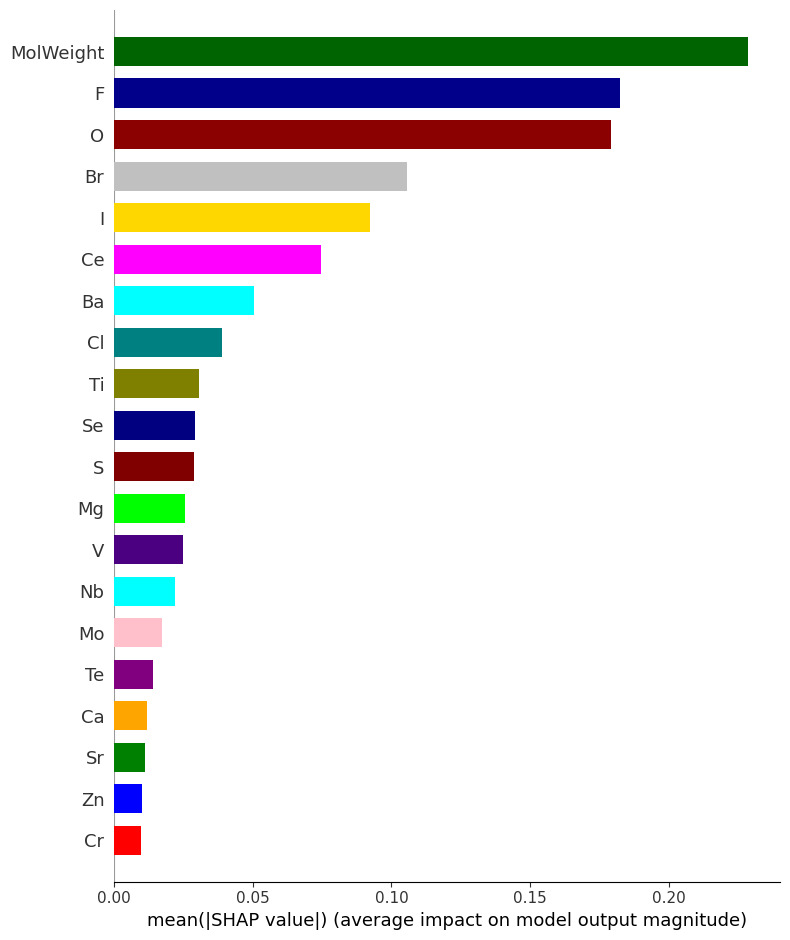

MSE for the best model: 0.05717253335394241
R^2 for the best model: 0.9230410623295494


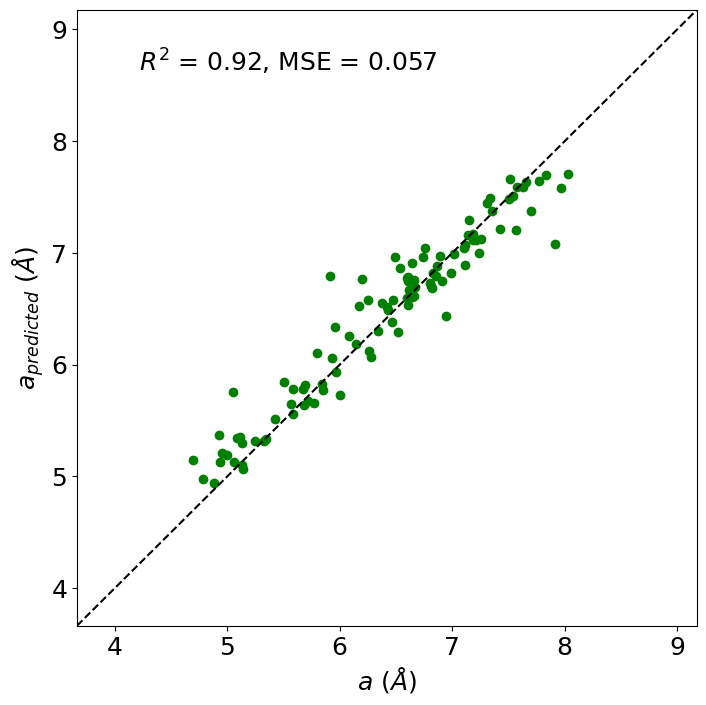

In [44]:
if hyperparameter:
  print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
  means = grid_result.cv_results_['mean_test_score']
  means_trainscores = grid_result.cv_results_['mean_train_score'] #mean_train_score
  stds = grid_result.cv_results_['std_test_score']
  params = grid_result.cv_results_['params']

  for test_mean, train_mean,stdev, param in zip(means,means_trainscores,stds,params):
    print("The test_mean is: %f and train_mean is: %f with std : %f and parameters: %r" % (test_mean,train_mean,stdev, param))

  #bestmodel = CatBoostRegressor(**grid_result.best_params_)

#Should load the best model directly or obtain it from above if hyperparameter is current
  best_model_hyper_parameter = joblib.load(dataplots+f'/best_model_hyperparameter_{mattype}.pkl')  # Update the file path accordingly

  # Extracting the model's class name
  #model_name = grid_result.best_estimator_.__class__.__name__
  ## Creating an instance of the model with the best parameters
  #bestmodel = eval(model_name + '(**grid_result.best_params_)')

  #best_model.fit(X_train, y_train)

  #Get the model accuracy on the training and the test set
  print('Accuracy Score of the training dataset %.5f' %best_model_hyper_parameter.score(X_train,y_train))
  print('Accuracy Score of test dataset %.5f' %best_model_hyper_parameter.score(X_test,y_test))

  # Load the best model from the saved file
  #best_model = joblib.load(dataplots+'/best_model_hyperparameter.pkl')  # Update the file path accordingly

  # List of colors for each feature (customize as needed)
  #feature_colors = ['red', 'blue', 'green', 'orange', 'purple', 'pink', 'cyan', 'indigo']

  try:
      Alg = best_model_hyper_parameter.__class__.__name__
      explainer = shap.TreeExplainer(best_model)
      shap_values = explainer.shap_values(X_test)
      print('Result for', Alg)
      print(shap_values)

      # Create a summary plot with custom feature colors
      shap.summary_plot(shap_values, X_test, plot_type="bar", color=feature_colors,show=False)
      if savplt:
        plt.savefig(dataplots+f'/shap_summary_feature_importance_hyperparameter_plot_{mattype}.png', dpi=400, bbox_inches='tight')
      plt.show()  # Display the plot
  except Exception as e:
      print(f"Exception occurred in {str(e)}")
      pass


  # Get the metrics for the best model from the dataframe
  best_predictions = best_model_hyper_parameter.predict(X_test)

  best_mse = metrics.mean_squared_error(y_test, best_predictions)
  best_r2 = metrics.r2_score(y_test, best_predictions)
  print(f"MSE for the best model: {best_mse}")
  print(f"R^2 for the best model: {best_r2}")

  # Plotting the predicted vs actual values
#  f, ax = plt.subplots(figsize=(8, 8))
#  plt.plot(y_test, best_predictions, 'o', color="green")
#  plt.ylabel(r"$E_g^{predicted}$ (eV)", fontsize=18)
#  plt.xlabel(r"$E_g$ (eV)", fontsize=18)
#  plt.xlim([0, 4])
#  plt.ylim([0, 4])
#  plt.xticks(fontsize=18)
#  plt.yticks(fontsize=18)
#  plt.plot([0, 4], [0, 4], 'k--')
#  plt.annotate(r"$R^2$ = %.2f, MSE = %.3f" % (best_r2, best_mse), (0.1, 3.5), fontsize=18)
#  plt.savefig(dataplots+f"/best_model_plot_latconst_actual_vs_predicted_hyperparameter_{mattype}.png", dpi=400)
#  plt.show()

  plot_predicted_vs_actual(y_test, best_predictions, best_r2, best_mse, mattype=mattype, save_plot=True)

In [45]:
!pip install bayesian-optimization

In [46]:
#import logging, os
#logging.disable(logging.WARNING)
#os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [47]:
# The DNN class architecture

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, initializers
from tensorflow.keras import layers, initializers, regularizers  # <-- Added regularizers
from tensorflow.keras.layers import Dropout, BatchNormalization, GaussianNoise,Activation  # <-- Added Dropout and BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from bayes_opt import BayesianOptimization
from tensorflow.keras.optimizers import Adam,Adadelta, RMSprop, Adagrad, SGD, Nadam
from tensorflow.keras.callbacks import LearningRateScheduler
import math


class CustomNeuralNetwork:
    def __init__(self, input_dim, output_dim, hidden_layers=(3, 500), activation='relu', loss='mae', optimizer='adam', noise_std=0.1, epochs=5000, optimize_noise=False):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_layers = hidden_layers
        self.activation = activation
        self.loss = loss
        self.noise_std = noise_std
        self.optimizer = optimizer
        self.n_layers = hidden_layers[0]
        self.nodes_per_layer = hidden_layers[1]
        self.epochs = epochs  # Number of epochs to train the model
        # Initialize optimize_noise
        self.optimize_noise = optimize_noise
        #self.lr_scheduler = LearningRateScheduler(self.step_decay())
        #self.lr_scheduler = LearningRateScheduler(self.exponential_decay(lr0=0.01, s=10))
        #self.lr_scheduler = LearningRateScheduler(self.exponential_decay(lr0=0.01, s=10))
        #self.lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1)
        #initial_learning_rate = 0.01
        #decay_steps = 100


        # Initialize best_noise before calling build_model
        self.best_noise = self.noise_std
        if self.optimize_noise:
            self.best_noise_tmp, _ = self.find_best_noise(X_train_main, y_train_main, X_val, y_val)
            self.best_noise = self.best_noise_tmp

        # Now build the model
        self.model = self.build_model()

    def create_model_noise(self, noise_amount=None, nodes=None):
        if noise_amount is None:
            noise_amount = getattr(self, 'best_noise', 0.10)
        if nodes is None:
            nodes = self.nodes_per_layer

        model_noise = keras.Sequential()

        # Input layer with added Gaussian Noise
        model_noise.add(GaussianNoise(noise_amount, input_shape=(self.input_dim,)))

        # Hidden layers
        for _ in range(self.n_layers):
            model_noise.add(layers.Dense(self.nodes_per_layer, activation=self.activation))

        # Output layer
        model_noise.add(layers.Dense(self.output_dim))

        # Compile the model
        model_noise.compile(optimizer=self.optimizer, loss=self.loss, metrics=['mse'])

        return model_noise



    def find_best_noise(self, X_train_main, y_train_main, X_val, y_val):
        def objective(noise_amount, nodes):
            nodes = int(nodes)
            model_find_best_noise = self.create_model_noise(noise_amount=noise_amount, nodes=nodes)
            history = model_find_best_noise.fit(X_train_main, y_train_main, validation_data=(X_val, y_val), epochs=self.epochs, verbose=0)
            return history.history['val_loss'][-1]

        pbounds = {
            'noise_amount': (0.01, 0.10),
            'nodes': (50, 400)
        }

        optimizer = BayesianOptimization(
            f=objective,
            pbounds=pbounds,
            random_state=1,
        )

        optimizer.maximize(init_points=5, n_iter=15)
        best_noise = optimizer.max['params']['noise_amount']
        best_nodes = optimizer.max['params']['nodes']

        print(f"Best noise amount: {best_noise:.4f}")
        print(f"Best nodes: {int(best_nodes)}")

        #print(optimizer.max)
        return best_noise,best_nodes

    def build_model(self):
        np.random.seed(rndseem)
        initializer = initializers.RandomNormal(stddev=0.01, seed=rndseem)
        noise_std = getattr(self, 'best_noise', 0)

        # Create the model
        model = keras.Sequential()
        model.add(layers.Dense(self.nodes_per_layer, input_dim=self.input_dim, activation=None,  # No activation here
                          kernel_initializer=initializer, name="layer1",
                          kernel_regularizer=regularizers.L1L2(l1=1e-4, l2=1e-3),
                          bias_regularizer=regularizers.L2(1e-3),
                          activity_regularizer=regularizers.L2(1e-4)))

        if noise_std > 0:
          model.add(GaussianNoise(noise_std))  # Add Gaussian noise
        model.add(Activation(self.activation))  # Activation here
        model.add(BatchNormalization())  # Add batch normalization

        for i in range(1, self.n_layers):
            model.add(layers.Dense(self.nodes_per_layer, activation=None,  # No activation here
                                  kernel_initializer=initializer, name=f"layer{i + 1}"))
            if noise_std > 0:
              model.add(GaussianNoise(noise_std))  # Add Gaussian noise for each hidden layer
            model.add(Activation(self.activation))  # Activate
            model.add(BatchNormalization())  # Add batch normalization for hidden layers
            model.add(Dropout(0.25))  # Add dropout to prevent overfitting
        model.add(layers.Dense(self.output_dim, name="output_layer"))



        model.compile(loss=self.loss, optimizer=self.optimizer, metrics=['mse'])

        return model


    def preprocess_data(self, X, y):
        # Scale the targets
        sc_y = StandardScaler()
        df_names = y.columns
        y_scaled = sc_y.fit_transform(y)
        y_scaled = pd.DataFrame(y_scaled, columns=df_names)

        # Scale the features
        sc_X = StandardScaler() #MinMaxScaler()
        df_names_x = X.columns
        X_scaled = sc_X.fit_transform(X)
        X_scaled = pd.DataFrame(X_scaled, columns=df_names_x)
        # Save the scalers for inverse transforming later, if needed
        self.scaler_X = sc_X
        self.scaler_y = sc_y
        return X_scaled, y_scaled



    def train(self, X_train, y_train, X_val=None, y_val=None, patience=20, model_checkpoint_path=dataplots+'/best_model.h5', early_stopping=False,epochs=None):
        """
        Train the neural network model.
        """
        if epochs is None:
          epochs = self.epochs
        #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=rndseem)

        if X_val is None or y_val is None:
            validation_data = None
        else:
            validation_data = (X_val, y_val)

        callbacks = []
        if early_stopping:
            es = EarlyStopping(verbose=1, patience=patience)
            callbacks.append(es)

        lrd = ReduceLROnPlateau(monitor='val_loss',
                        factor=0.20,  # Reduce the learning rate by
                        patience=patience,
                        verbose=1,
                        mode='min',
                        threshold_mode='rel',
                        min_delta=1e-4,  # Minimum change to consider as improvement
                        cooldown=5,  # Wait for 5 epochs before potentially applying further reductions
                        min_lr=1e-6)  # Set a floor for the learning rate

        model_checkpoint = ModelCheckpoint(model_checkpoint_path, save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1)
        callbacks.extend([lrd, model_checkpoint]) #, self.lr_scheduler

        mdl_history = self.model.fit(X_train, y_train,
                                     epochs=epochs,
                                     validation_data=validation_data,
                                     shuffle = True,
                                     batch_size = 64,
                                     callbacks=callbacks)

        return mdl_history

    def plot_loss(self, history, filename=None):
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Error')
        plt.legend()
        plt.grid(True)

        if filename:
            plt.savefig(filename, dpi=400, bbox_inches='tight')

        plt.show()



    def improved_plot_loss(self, history, title="Model Loss", xlabel="Epoch", ylabel="Error",
                          fontsize=14, linewidth=2.5, figure_size=(10, 6), show_grid=False,filename=None):
        """
        Plot the training and validation loss with improved visual features.

        Args:
        - history (History object): History object containing training/validation loss data.
        - title (str): Title for the plot.
        - xlabel (str): X-axis label.
        - ylabel (str): Y-axis label.
        - fontsize (int): Base fontsize for the title, labels, ticks, and legend.
        - linewidth (float): Line width of the plot lines.
        - figure_size (tuple): Figure size.
        - filename (str or None): If a string is provided, the plot will be saved to the given filename.

        Returns:
        - None: Displays the plot.
        """
        plt.figure(figsize=figure_size)
        plt.tick_params(axis='both', length=5, width=2)
        # Grid settings
        if show_grid:
            plt.rcParams['axes.grid'] = True
            plt.rcParams['grid.linestyle'] = '--'
            plt.rcParams['grid.linewidth'] = 0.5
        else:
            plt.rcParams['axes.grid'] = False

        plt.rcParams.update({'font.size': fontsize})


        plt.plot(history.history['loss'], label='Train Loss', linewidth=linewidth)
        plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=linewidth)

        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend()
        plt.gca().spines['bottom'].set_linewidth(1.5)
        plt.gca().spines['left'].set_linewidth(1.5)

        if filename:
            plt.savefig(filename, dpi=400, bbox_inches='tight')
        plt.show()


    def historytrend(self,mdl_history):
      #Check the losses
      hist = pd.DataFrame(mdl_history.history)
      hist['epoch'] = mdl_history.epoch
      return hist.tail()


    def evaluate(self, X_test, y_test):
        test_loss = self.model.evaluate(X_test, y_test)
        return test_loss

    def predict(self, X_test):
        return self.model.predict(X_test)

    def r2_score(self, y_true, y_pred):
        return r2_score(y_true, y_pred)

    def compute_shap_values(self, X, sample_size=100):
        """
        Compute SHAP values for the given dataset X.

        Args:
        - X (pd.DataFrame): The dataset for which SHAP values are to be computed.
        - sample_size (int): Number of samples to be used as background dataset for SHAP.

        Returns:
        - List of SHAP values for each target.
        """
        background = X.sample(sample_size)  # Sample a background dataset
        explainer = shap.DeepExplainer(self.model, background.values)
        #explainer = shap.GradientExplainer(self.model, background.values)
        shap_values = explainer.shap_values(X.values)
        return shap_values

    def plot_shap_values(self, shap_values, X, class_names=None, save_path=None):
        """
        Plot SHAP summary plots for given SHAP values and dataset X.

        Args:
        - shap_values (list): SHAP values computed using compute_shap_values method.
        - X (pd.DataFrame): The dataset for which SHAP values were computed.
        - class_names (list, optional): Names of the target classes for identification (only required for multi-output).
        - save_path (str, optional): Directory path where the plots should be saved. If None, plots won't be saved.
        """
        if class_names is None and isinstance(shap_values, list):
            class_names = [f"Target {i+1}" for i in range(len(shap_values))]

        if isinstance(shap_values, list):
            for i, shap_val in enumerate(shap_values):
                print(f"SHAP summary plot for target {i + 1}:")
                shap.summary_plot(shap_val, X, plot_type="bar",color=feature_colors,show=False)

                if save_path:
                    file_name = f"shap_summary_feature_importance_dnn_{i + 1}.png"
                    full_path = os.path.join(save_path, file_name)
                    plt.savefig(full_path, dpi=400, bbox_inches='tight')
                    plt.clf()  # Clear the current figure for the next one

            print("SHAP summary plot for all targets combined:")
            combined_shap_values = np.sum(np.abs(np.array(shap_values)), axis=0)
            print(combined_shap_values)
            shap.summary_plot(combined_shap_values, X, feature_names=X.columns, plot_type="bar", color=feature_colors, show=False)
            if save_path:
                full_path = os.path.join(save_path, "shap_summary_feature_importance_dnn_combined.png")
                plt.savefig(full_path, dpi=400, bbox_inches='tight')
        else:
            shap.summary_plot(shap_values, X,plot_type="bar",color=feature_colors,show=False)
            if save_path:
                full_path = os.path.join(save_path, "shap_summary_feature_importance_dnn.png")
                plt.savefig(full_path, dpi=400, bbox_inches='tight')

In [48]:
#For data augmentation

class DataAugmenter:
    def __init__(self, mean=0, std=0.10, num_augmented_samples=2):
        self.mean = mean
        self.std = std
        self.num_augmented_samples = num_augmented_samples

    def add_gaussian_noise(self, data):
        """Add Gaussian noise to data."""
        noise = np.random.normal(self.mean, self.std, data.shape)
        return data + noise

    def augment_data_continuous(self, X, y):
        """Generate noisy versions of each sample for continuous data."""
        augmented_X = []
        augmented_y = []

        for sample, label in zip(X, y):
            for _ in range(self.num_augmented_samples):
                noisy_sample = self.add_gaussian_noise(sample)
                augmented_X.append(noisy_sample)
                augmented_y.append(label)

        augmented_X = np.array(augmented_X)
        augmented_y = np.array(augmented_y)

        return augmented_X, augmented_y

    def shuffle_dataset(self, X, y):
        """Shuffle data and labels."""
        indices = np.arange(X.shape[0])
        np.random.shuffle(indices)
        return X[indices], y[indices]

    def augment_and_shuffle(self, X, y):
        augmented_X, augmented_y = self.augment_data_continuous(X, y)
        return self.shuffle_dataset(augmented_X, augmented_y)


In [49]:
#At least until next update of TensorFlow, you need this to be able to plot feature importance with shap
from tensorflow.compat.v1.keras.backend import get_session
tf.compat.v1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


Train on 8140 samples, validate on 102 samples
Epoch 1/400
8128/8140 [============================>.] - ETA: 0s - loss: 0.9575 - mean_squared_error: 1.6772

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.




Epoch 1: val_loss improved from inf to 0.73219, saving model to ./best_model.h5
8140/8140 [==============================] - 3s 341us/sample - loss: 0.9573 - mean_squared_error: 1.6765 - val_loss: 0.7322 - val_mean_squared_error: 1.0261 - lr: 0.0010
Epoch 2/400
8064/8140 [============================>.] - ETA: 0s - loss: 0.5709 - mean_squared_error: 0.7100
Epoch 2: val_loss improved from 0.73219 to 0.66973, saving model to ./best_model.h5
8140/8140 [==============================] - 1s 128us/sample - loss: 0.5699 - mean_squared_error: 0.7075 - val_loss: 0.6697 - val_mean_squared_error: 1.0003 - lr: 0.0010
Epoch 3/400
8140/8140 [==============================] - ETA: 0s - loss: 0.4720 - mean_squared_error: 0.5159
Epoch 3: val_loss improved from 0.66973 to 0.51134, saving model to ./best_model.h5
8140/8140 [==============================] - 1s 136us/sample - loss: 0.4720 - mean_squared_error: 0.5159 - val_loss: 0.5113 - val_mean_squared_error: 0.6928 - lr: 0.0010
Epoch 4/400
7936/8140 [

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



,loss,mean_squared_error,val_loss,val_mean_squared_error,lr,epoch
395,0.170055,0.052807,0.333739,0.269945,0.000001,395
396,0.167034,0.049494,0.332773,0.269252,0.000001,396
397,0.167348,0.050770,0.332560,0.268424,0.000001,397
398,0.168400,0.051114,0.333168,0.269404,0.000001,398
399,0.167175,0.052200,0.332415,0.268824,0.000001,399


-------------------------------------------------------------------------------------------------
This is the traing and test accuracy of the DNN model
Test Loss: [0.3324146416841769, 0.26882416]
The Training and Test data R-squared values are: 0.9976249739988905 and  0.7225335322180738
-------------------------------------------------------------------------------------------------


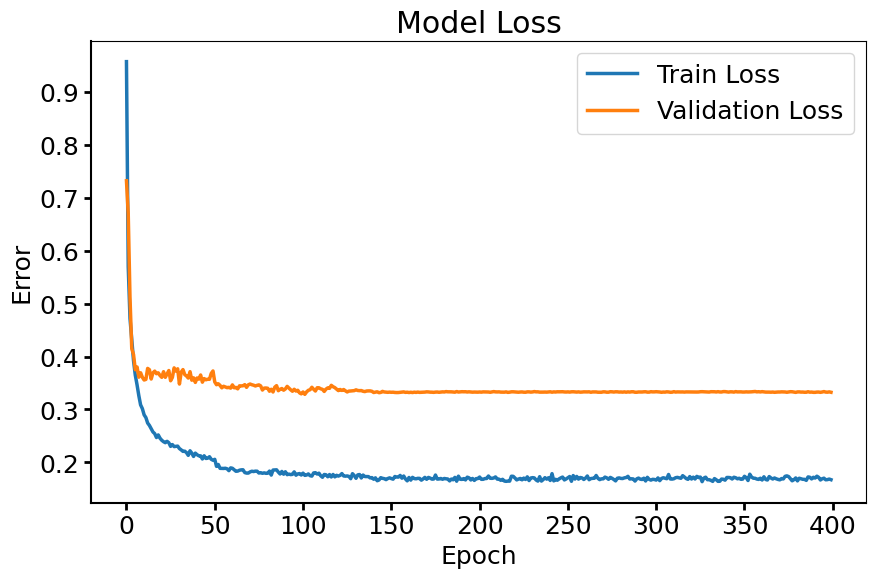

/usr/local/lib/python3.10/dist-packages/shap/explainers/_deep/deep_tf.py:100: UserWarning:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.



SHAP summary plot for target 1:
SHAP summary plot for target 2:
SHAP summary plot for target 3:
SHAP summary plot for all targets combined:
[[0.41554199 0.15142321 0.10430082 ... 1.28629813 0.00736857 0.59168723]
 [0.16122197 0.17322265 0.09687705 ... 0.07738834 0.01710072 1.10866378]
 [0.13600461 0.05320507 0.05870947 ... 0.03805423 0.02622094 0.72763399]
 ...
 [0.19086354 0.05010567 0.04027799 ... 0.0481753  0.01801187 0.66358266]
 [0.05104893 0.02362139 0.17628881 ... 0.06557342 0.02183481 0.33624472]
 [0.14135552 0.08881295 0.05310309 ... 0.1440039  0.01661263 0.82408736]]


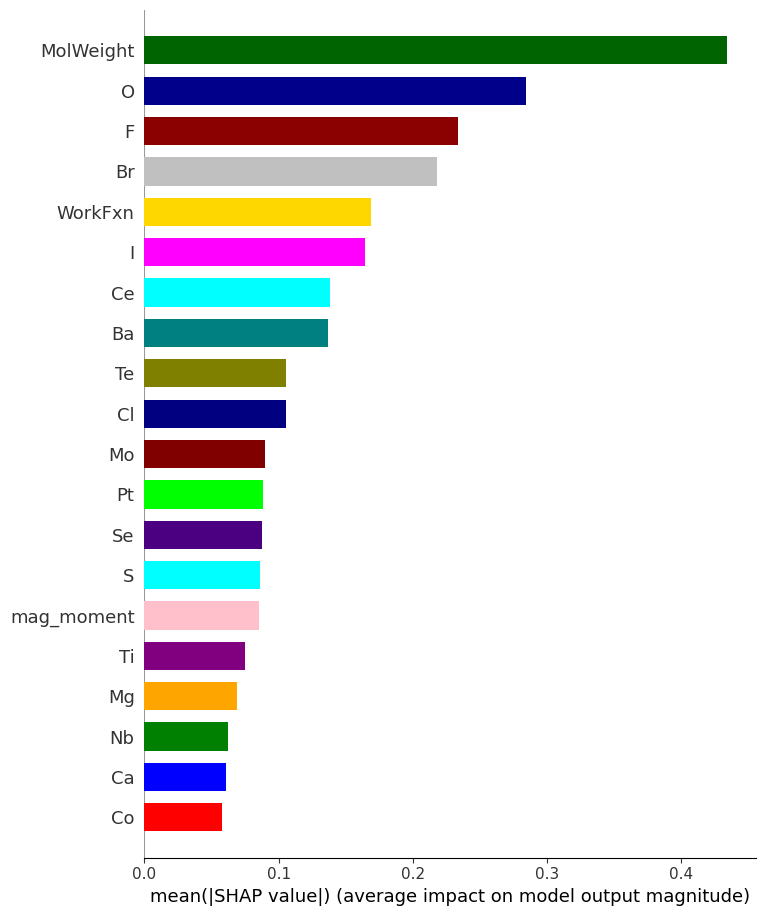

In [51]:
# Data augmentation and noise added

X_nn = data_clean.drop(columns=['Bandgap','Y2D','lat_const'],axis=1)  #,'WorkFxn','mag_moment'
y_nn = data_clean[['Bandgap','Y2D','lat_const']]

epochs = 400
optimize_noise = False
data_agumentation = True
early_stopping = False
best_noise = 0.09
num_augmented_samples = 20
hidden_layers=(4, 200)

nn_temp = CustomNeuralNetwork(input_dim=X_nn.shape[1], output_dim=y_nn.shape[1],
                              hidden_layers=hidden_layers, activation='relu', optimizer='adam', noise_std=best_noise, #RMSprop
                              epochs=epochs, optimize_noise=False)

# Preprocess the data
X_scaled, y_scaled = nn_temp.preprocess_data(X_nn, y_nn)

# Split the preprocessed data
X_main, X_test, y_main, y_test = train_test_split(X_scaled, y_scaled, test_size=test_size, random_state=rndseem)


#Note, both noise and data augmentation is only done on the training dataset



if data_agumentation:
  X_train_np = X_main.to_numpy()
  y_train_np = y_main.to_numpy()
  augmenter = DataAugmenter(mean=0, std=best_noise, num_augmented_samples=num_augmented_samples)
  augmented_X_train, augmented_y_train = augmenter.augment_and_shuffle(X_train_np, y_train_np)

  if optimize_noise:
    X_train_main, X_val, y_train_main, y_val = train_test_split(augmented_X_train, augmented_y_train, test_size=test_size, random_state=rndseem)
    best_noise,best_node = nn_temp.find_best_noise(X_train_main, y_train_main, X_val, y_val)
    print(f"Best noise value: {best_noise}")
    hidden_layers=(hidden_layers[1], best_node)
    epochs = int(best_node)
    best_noise = best_noise
  else:
    best_noise = best_noise #Default value


  # Instantiate the custom neural network
  model_nn = CustomNeuralNetwork(input_dim=X_scaled.shape[1], output_dim=y_scaled.shape[1],
                          hidden_layers=hidden_layers, activation='relu', noise_std=best_noise,
                          epochs=epochs, optimize_noise=optimize_noise)
  mdl_history = model_nn.train(augmented_X_train, augmented_y_train, X_test, y_test, early_stopping=early_stopping, epochs=epochs)
  y_pred_train = model_nn.predict(augmented_X_train)
  r2_train = model_nn.r2_score(y_pred_train, augmented_y_train)
else:

  if optimize_noise:
    X_train_main, X_val, y_train_main, y_val = train_test_split(X_main, y_main, test_size=test_size, random_state=rndseem)
    best_noise,best_node = nn_temp.find_best_noise(X_train_main, y_train_main, X_val, y_val)
    print(f"Best noise value: {best_noise}")
    hidden_layers=(hidden_layers[1], best_node)
    epochs = int(best_node)
    best_noise = best_noise
  else:
    best_noise = best_noise #Default value

    # Instantiate the custom neural network
  model_nn = CustomNeuralNetwork(input_dim=X_scaled.shape[1], output_dim=y_scaled.shape[1],
                          hidden_layers=hidden_layers, activation='relu', noise_std=best_noise,
                          epochs=epochs, optimize_noise=optimize_noise)
  mdl_history = model_nn.train(X_main, y_main, X_test, y_test, early_stopping=early_stopping, epochs=epochs)
  y_pred_train = model_nn.predict(X_main)
  r2_train = model_nn.r2_score(y_pred_train, y_main)


# Evaluate the model on the test set
test_loss = model_nn.evaluate(X_test, y_test)

# Predict on the test set quantify accuracy usig calculate R-squared

y_pred = model_nn.predict(X_test)
r2 = model_nn.r2_score(y_test, y_pred)

display(model_nn.historytrend(mdl_history))



print("-------------------------------------------------------------------------------------------------")
print("This is the traing and test accuracy of the DNN model")
print(f"Test Loss: {test_loss}") #mse for test
print(f"The Training and Test data R-squared values are: {r2_train} and  {r2}")
print("-------------------------------------------------------------------------------------------------")

# Plot the loss
if savplt:
  #model_nn.plot_loss(mdl_history,filename=dataplots+'/dnn_loss_plot.png')
  model_nn.improved_plot_loss(mdl_history, title="Model Loss", xlabel="Epoch", ylabel="Error",
                          fontsize=18, linewidth=2.5, figure_size=(10, 6), filename=dataplots+'/dnn_loss_plot_combined.png')
  sample_size = min(100, len(X_test))
  shap_values = model_nn.compute_shap_values(X_test, sample_size=sample_size)

  model_nn.plot_shap_values(shap_values, X_test, class_names=y_test.columns, save_path=dataplots)